In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

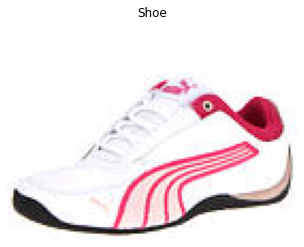

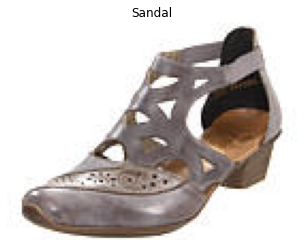

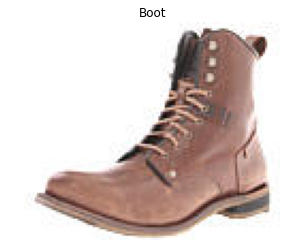

In [ ]:
### show one picutre from each class ### 
import random
import os
path_folder = '/kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset' # I used Kaggle notebook instead of colab
classes=os.listdir(path_folder)
for each_class in classes:
  class_path = os.path.join(path_folder,each_class)
  picutre = random.choice(os.listdir(class_path))
  pic_path = os.path.join(class_path, picutre)
  img = plt.imread(pic_path)
  plt.imshow(img)
  plt.title(each_class)
  plt.axis("off")
  plt.show()

In [ ]:
import multiprocessing as mp
resize_size = 28
batch_size = 64
#channel_output = 1
transform = transforms.Compose([transforms.Resize((resize_size, resize_size)), #transforms.Grayscale(num_output_channels=channel_output),
                                transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.ImageFolder(root=path_folder, transform=transform)
# 60%,30%,10% train,test,validation split
val_size = len(dataset) - int(0.6 * len(dataset)) - int(0.3 * len(dataset))
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(0.6 * len(dataset)), int(0.3 * len(dataset)), val_size])
#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=mp.cpu_count())
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=mp.cpu_count())
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=mp.cpu_count())

In [2]:
def train(model, trainloader, testloader, valloader, criterion, optimizer, epochs, writer=None, writer_name =""):
    model.train()
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)

            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_acc = running_corrects.double() / len(trainloader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        if writer:
            writer.add_scalar(f'Training loss for {writer_name}', epoch_loss, epoch)
            writer.add_scalar(f'Training accuracy for {writer_name}', epoch_acc, epoch)
        print('Epoch {}/{} - Training loss: {:.4f} - Training accuracy: {:.4f}'.format(epoch+1, epochs, epoch_loss, epoch_acc))
        test_loss_, test_acc_ = test(model, testloader, criterion)
        test_loss.append(test_loss_)
        test_acc.append(test_acc_)
        if writer:
            writer.add_scalar(f'Test loss for {writer_name}', test_loss_, epoch)
            writer.add_scalar(f'Test accuracy for {writer_name}', test_acc_, epoch)
        val_loss_, val_acc_ = validate(model, valloader, criterion)
        val_loss.append(val_loss_)
        val_acc.append(val_acc_)
        if writer:
            writer.add_scalar(f'Validation loss for {writer_name}', val_loss_, epoch)
            writer.add_scalar(f'Validation accuracy for {writer_name}', val_acc_, epoch)
    print('Finished Training')
    return train_loss, train_acc, test_loss, test_acc, val_loss, val_acc

def test(model, testloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(testloader.dataset)
    epoch_acc = running_corrects.double() / len(testloader.dataset)
    print('Test loss: {:.4f} - Test accuracy: {:.4f}'.format(epoch_loss, epoch_acc))
    model.train()
    return epoch_loss, epoch_acc

def validate(model, valloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(valloader.dataset)
    epoch_acc = running_corrects.double() / len(valloader.dataset)
    print('Validation loss: {:.4f} - Validation accuracy: {:.4f}'.format(epoch_loss, epoch_acc))
    model.train()
    return epoch_loss, epoch_acc

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False):

    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title=title, ylabel='True label', xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# model with different lr to choose best one
def train_model_different_lr(model_class,learning_rates, epochs, trainloader, testloader, valloader, writer=None, writer_name=None):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    val_loss = []
    val_acc = []
    for lr in learning_rates:
        model = model_class.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_loss_, train_acc_, test_loss_, test_acc_, val_loss_, val_acc_ = train(model, trainloader, testloader, valloader, criterion, optimizer, epochs, writer, writer_name)
        train_loss.append(train_loss_[-1])
        train_acc.append(train_acc_[-1])
        test_loss.append(test_loss_[-1])
        test_acc.append(test_acc_[-1])
        val_loss.append(val_loss_[-1])
        val_acc.append(val_acc_[-1])
    return train_loss, train_acc, test_loss, test_acc, val_loss, val_acc

# plot result with different lr to choose best one
def plot_result_different_learning_rate(model_class, epochs):
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    train_loss, train_acc, test_loss, test_acc, val_loss, val_acc = train_model_different_lr(model_class,learning_rates, epochs, trainloader, testloader, valloader)
    # clear cell outputs
    from IPython.display import clear_output
    clear_output()
    for i in range(len(learning_rates)):
        print('learning rate: {}'.format(learning_rates[i]))
        print('train loss: {:.4f} - train accuracy: {:.4f}'.format(train_loss[i], train_acc[i]))
        print('test loss: {:.4f} - test accuracy: {:.4f}'.format(test_loss[i], test_acc[i]))
        print('val loss: {:.4f} - val accuracy: {:.4f}'.format(val_loss[i], val_acc[i]))
        print('---------------------------------------------')
    print('best learning rate based on val accuracy: {}'.format(learning_rates[val_acc.index(max(val_acc))]))
    print('best learning rate based on val loss: {}'.format(learning_rates[val_loss.index(min(val_loss))]))
    print('---------------------------------------------')
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(learning_rates, train_loss, label='train')
    plt.plot(learning_rates, test_loss, label='test')
    plt.plot(learning_rates, val_loss, label='val')
    plt.xlabel('learning rate')
    plt.ylabel('loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(learning_rates, train_acc, label='train')
    plt.plot(learning_rates, test_acc, label='test')
    plt.plot(learning_rates, val_acc, label='val')
    plt.xlabel('learning rate')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    return learning_rates[val_acc.index(max(val_acc))] #best_learning_rate
    
class DropBlock2D(nn.Module): # source of origin : https://github.com/miguelvr/dropblock/
    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return xblob/master/dropblock/dropblock.py
    
        else:
            gamma = self._compute_gamma(x)
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()
            mask = mask.to(x.device)
            block_mask = self._compute_block_mask(mask)
            out = x * block_mask[:, None, :, :]
            out = out * block_mask.numel() / block_mask.sum()
            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)


learning rate: 0.0001

train loss: 0.6594 - train accuracy: 0.8939

test loss: 0.6544 - test accuracy: 0.8969

val loss: 0.6414 - val accuracy: 0.9080

---------------------------------------------

learning rate: 0.001

train loss: 0.6598 - train accuracy: 0.8900

test loss: 0.6653 - test accuracy: 0.8842

val loss: 0.6482 - val accuracy: 0.9027

---------------------------------------------

learning rate: 0.01

train loss: 1.2117 - train accuracy: 0.3398

test loss: 1.2277 - test accuracy: 0.3238

val loss: 1.2281 - val accuracy: 0.3233

---------------------------------------------

learning rate: 0.1

train loss: 1.2117 - train accuracy: 0.3398

test loss: 1.2277 - test accuracy: 0.3238

val loss: 1.2281 - val accuracy: 0.3233

---------------------------------------------

best learning rate based on val accuracy: 0.0001

best learning rate based on val loss: 0.0001

---------------------------------------------


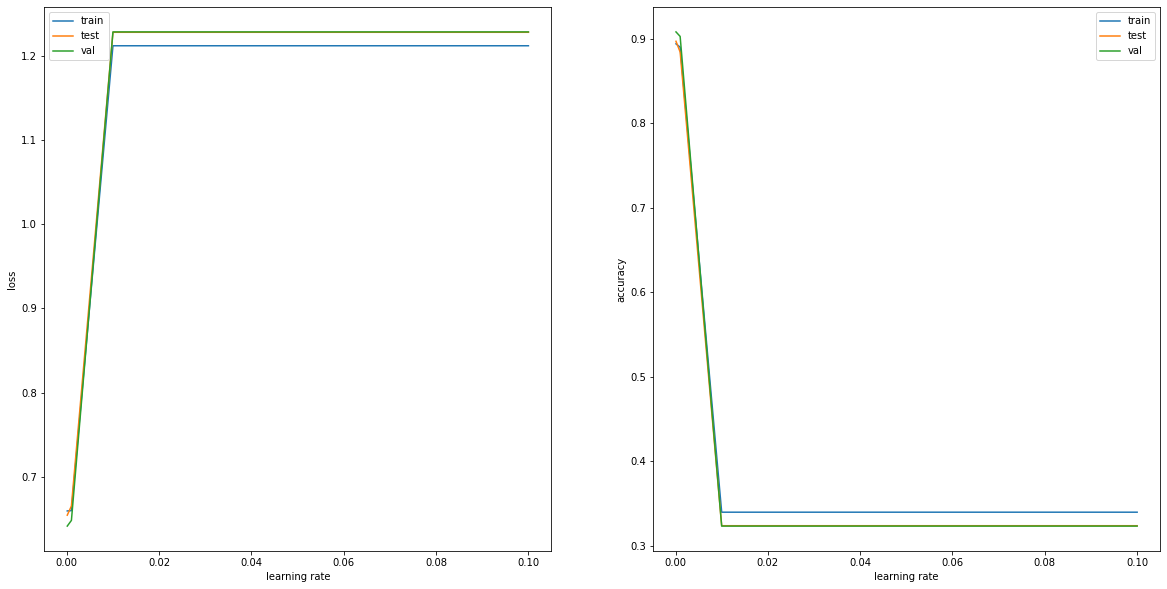

In [ ]:
# create a MLP model with 2 hidden layers for classification dataset and softmax activation function and dropout of 0.2
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 3, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = x.view(-1, 28 * 28 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return F.softmax(self.fc3(x), dim=1)
    
### choose learning rate in 5epochs ###
leraning_rate = plot_result_different_learning_rate(MLP(),epochs = 5)

In [ ]:
# train the MLP model with 10 epoch with learning rate of 0.001 and momentum of 0.9 with Adam optimizer
model_MLP = MLP()
writer = SummaryWriter('runs/mlp')
model_MLP.to(device)
criterion = nn.CrossEntropyLoss()
epochs = 20
optimizer = optim.Adam(model_MLP.parameters(), lr=leraning_rate) #learning_rate selected base val_acc in previous cell
train_loss_MLP, train_acc_MLP, test_loss_MLP, test_acc_MLP, val_loss_MLP, val_acc_MLP = train(model_MLP, trainloader, testloader, valloader, criterion, optimizer, epochs, writer=writer, writer_name = "MLP")
# !tensorboard dev upload --logdir runs/mlp \
# --name "MLP with 10 epoch" \
# --description "MLP l"
# I plot my result with tensoarboard and screenshot is in folder


Epoch 1/20 - Training loss: 0.7986 - Training accuracy: 0.7822

Test loss: 0.7304 - Test accuracy: 0.8251

Validation loss: 0.7219 - Validation accuracy: 0.8340

Epoch 2/20 - Training loss: 0.7013 - Training accuracy: 0.8559

Test loss: 0.6816 - Test accuracy: 0.8747

Validation loss: 0.6668 - Validation accuracy: 0.8913

Epoch 3/20 - Training loss: 0.6789 - Training accuracy: 0.8762

Test loss: 0.6708 - Test accuracy: 0.8858

Validation loss: 0.6547 - Validation accuracy: 0.9047

Epoch 4/20 - Training loss: 0.6662 - Training accuracy: 0.8881

Test loss: 0.6565 - Test accuracy: 0.9004

Validation loss: 0.6455 - Validation accuracy: 0.9060

Epoch 5/20 - Training loss: 0.6586 - Training accuracy: 0.8944

Test loss: 0.6494 - Test accuracy: 0.9060

Validation loss: 0.6359 - Validation accuracy: 0.9227

Epoch 6/20 - Training loss: 0.6518 - Training accuracy: 0.9022

Test loss: 0.6460 - Test accuracy: 0.9064

Validation loss: 0.6350 - Validation accuracy: 0.9180

Epoch 7/20 - Training loss: 

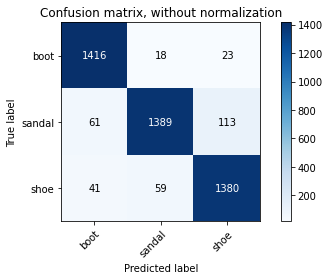

~~~~~~~~~~~~~~~~~ Classification Report ~~~~~~~~~~~~~~~

              precision    recall  f1-score   support



        boot       0.93      0.97      0.95      1457

      sandal       0.95      0.89      0.92      1563

        shoe       0.91      0.93      0.92      1480



    accuracy                           0.93      4500

   macro avg       0.93      0.93      0.93      4500

weighted avg       0.93      0.93      0.93      4500




In [ ]:
#plot the confusion matrix
y_true = []
y_pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_MLP(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
class_names = np.array(['boot', 'sandal', 'shoe'])
plot_confusion_matrix(np.array(y_true), np.array(y_pred), classes=class_names, normalize=False)
plt.show()

print("~~~~~~~~~~~~~~~~~ Classification Report ~~~~~~~~~~~~~~~")
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
# report number of parameters in the model
def number_of_parameters(model):
    paramters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return paramters
print('The defined MLP model has {} trainable parameters'.format(number_of_parameters(model_MLP)))

The defined MLP model has 1270787 trainable parameters


learning rate: 0.0001

train loss: 0.6584 - train accuracy: 0.8948

test loss: 0.6547 - test accuracy: 0.8980

val loss: 0.6424 - val accuracy: 0.9113

---------------------------------------------

learning rate: 0.001

train loss: 0.6040 - train accuracy: 0.9477

test loss: 0.6071 - test accuracy: 0.9440

val loss: 0.5984 - val accuracy: 0.9533

---------------------------------------------

learning rate: 0.01

train loss: 1.2279 - train accuracy: 0.3236

test loss: 1.2041 - test accuracy: 0.3473

val loss: 1.2014 - val accuracy: 0.3500

---------------------------------------------

learning rate: 0.1

train loss: 1.2279 - train accuracy: 0.3236

test loss: 1.2041 - test accuracy: 0.3473

val loss: 1.2014 - val accuracy: 0.3500

---------------------------------------------

best learning rate based on val accuracy: 0.001

best learning rate based on val loss: 0.001

---------------------------------------------


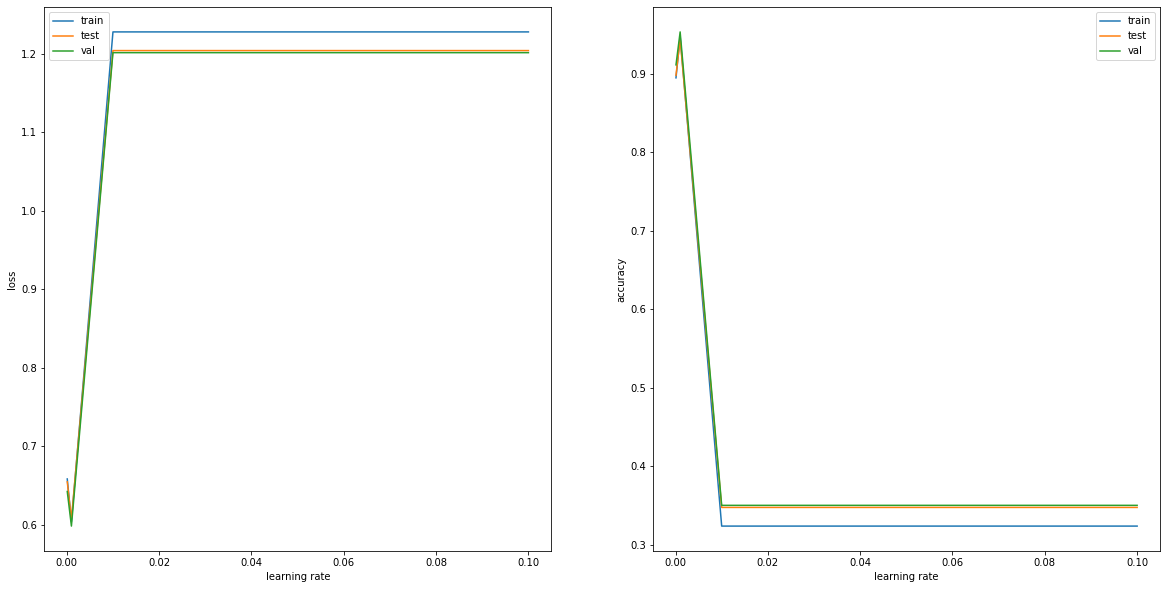

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)
### choose learning rate ###
learning_rate = plot_result_different_learning_rate(CNN(), epochs = 5)

In [ ]:
# train the CNN model with 10 epoch with learning rate of 0.001 and momentum of 0.9 with Adam optimizer
model_CNN = CNN()
writer = SummaryWriter('runs/CNN_dropout')
model_CNN.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN.parameters(), lr=learning_rate) #learning_rate selected base val_acc in previous cell
train_loss_CNN, train_acc_CNN, test_loss_CNN, test_acc_CNN, val_loss_CNN, val_acc_CNN = train(model_CNN, trainloader, testloader, valloader, criterion, optimizer, epochs, writer=writer, writer_name = "CNN")
torch.save(model_CNN.state_dict(), 'model_CNN.pt')


Epoch 1/20 - Training loss: 0.7390 - Training accuracy: 0.8117

Test loss: 0.6579 - Test accuracy: 0.8971

Validation loss: 0.6502 - Validation accuracy: 0.9007

Epoch 2/20 - Training loss: 0.6396 - Training accuracy: 0.9137

Test loss: 0.6204 - Test accuracy: 0.9344

Validation loss: 0.6144 - Validation accuracy: 0.9373

Epoch 3/20 - Training loss: 0.6196 - Training accuracy: 0.9317

Test loss: 0.6079 - Test accuracy: 0.9456

Validation loss: 0.6026 - Validation accuracy: 0.9493

Epoch 4/20 - Training loss: 0.6086 - Training accuracy: 0.9437

Test loss: 0.6080 - Test accuracy: 0.9440

Validation loss: 0.6052 - Validation accuracy: 0.9420

Epoch 5/20 - Training loss: 0.6029 - Training accuracy: 0.9500

Test loss: 0.5970 - Test accuracy: 0.9553

Validation loss: 0.5936 - Validation accuracy: 0.9587

Epoch 6/20 - Training loss: 0.5961 - Training accuracy: 0.9550

Test loss: 0.5997 - Test accuracy: 0.9511

Validation loss: 0.5943 - Validation accuracy: 0.9560

Epoch 7/20 - Training loss: 

~~~~~~~~~~~~~~~~~ Classification Report ~~~~~~~~~~~~~~~

              precision    recall  f1-score   support



        boot       0.97      0.98      0.98      1457

      sandal       0.98      0.95      0.96      1563

        shoe       0.95      0.98      0.96      1480



    accuracy                           0.97      4500

   macro avg       0.97      0.97      0.97      4500

weighted avg       0.97      0.97      0.97      4500




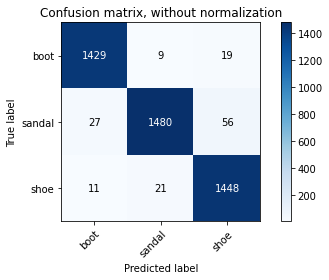

In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
class_names = np.array(['boot', 'sandal', 'shoe'])

# plot the confusion matrix for CNN model
plot_confusion_matrix(np.array(y_true), np.array(y_pred), classes=class_names, normalize=False)

# report the classification report for CNN model
print("~~~~~~~~~~~~~~~~~ Classification Report ~~~~~~~~~~~~~~~")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
print('The defined MLP model has {} trainable parameters'.format(number_of_parameters(model_CNN)))
print('The MLP model has {} trainable parameters more than CNN model'.format(number_of_parameters(model_MLP) - number_of_parameters(model_CNN)))

The defined MLP model has 1199555 trainable parameters

The MLP model has 71232 trainable parameters more than CNN model


learning rate: 0.0001

train loss: 0.6696 - train accuracy: 0.8871

test loss: 0.6461 - test accuracy: 0.9142

val loss: 0.6368 - val accuracy: 0.9260

---------------------------------------------

learning rate: 0.001

train loss: 0.6050 - train accuracy: 0.9467

test loss: 0.6037 - test accuracy: 0.9469

val loss: 0.6008 - val accuracy: 0.9487

---------------------------------------------

learning rate: 0.01

train loss: 1.2279 - train accuracy: 0.3236

test loss: 1.2041 - test accuracy: 0.3473

val loss: 1.2014 - val accuracy: 0.3500

---------------------------------------------

learning rate: 0.1

train loss: 1.2279 - train accuracy: 0.3236

test loss: 1.2041 - test accuracy: 0.3473

val loss: 1.2014 - val accuracy: 0.3500

---------------------------------------------

best learning rate based on val accuracy: 0.001

best learning rate based on val loss: 0.001

---------------------------------------------


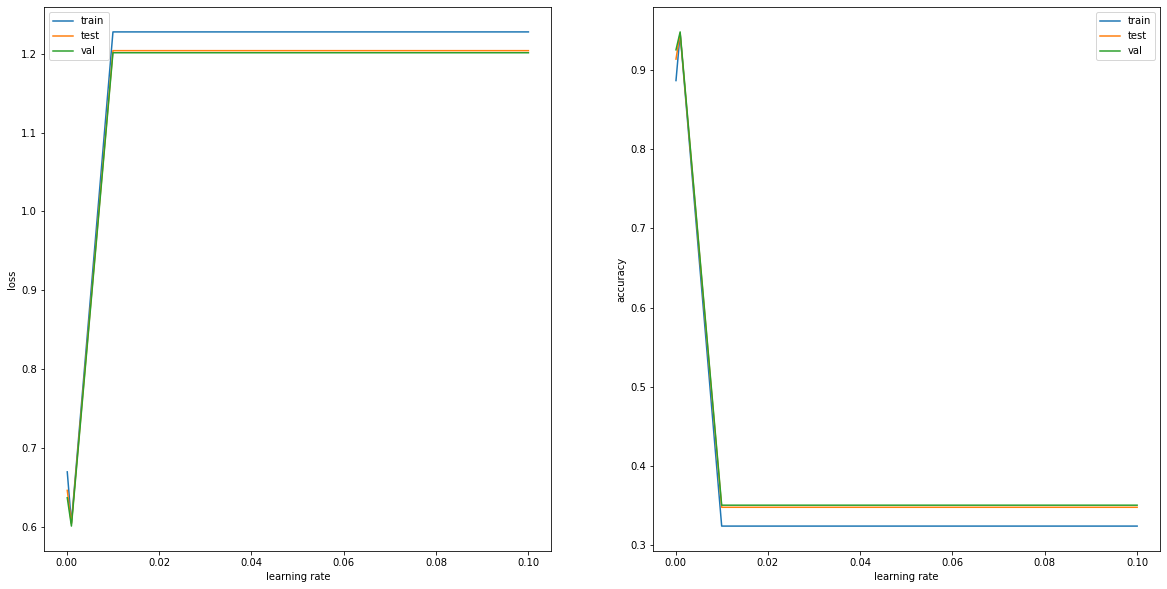

In [ ]:
# create the CNN model with block dropout layer
class CNN_block(nn.Module):
    def __init__(self):
        super(CNN_block, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 3)
        self.dropout = DropBlock2D(drop_prob = 0.2, block_size = 3)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)
### choose learning rate ###
learning_rate = plot_result_different_learning_rate(CNN_block(),epochs = 5)

In [ ]:
# train the CNN model with block dropout layer with 10 epoch with learning rate of 0.001 and momentum of 0.9 with Adam optimizer
model_CNN_block = CNN_block()
model_CNN_block.to(device)
writer = SummaryWriter('runs/model_CNN_block')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN_block.parameters(), lr=learning_rate)
train_loss_CNN_block, train_acc_CNN_block, test_loss_CNN_block, test_acc_CNN_block, val_loss_CNN_block, val_acc_CNN_block = train(model_CNN_block, trainloader, testloader, valloader, criterion, optimizer, epochs, writer=writer, writer_name = "CNN_block_dropout")
torch.save(model_CNN_block.state_dict(), 'model_CNN_block.pt')

Epoch 1/20 - Training loss: 0.7650 - Training accuracy: 0.7851

Test loss: 0.6432 - Test accuracy: 0.9104

Validation loss: 0.6298 - Validation accuracy: 0.9253

Epoch 2/20 - Training loss: 0.6476 - Training accuracy: 0.9042

Test loss: 0.6202 - Test accuracy: 0.9320

Validation loss: 0.6086 - Validation accuracy: 0.9433

Epoch 3/20 - Training loss: 0.6267 - Training accuracy: 0.9250

Test loss: 0.6073 - Test accuracy: 0.9460

Validation loss: 0.5994 - Validation accuracy: 0.9527

Epoch 4/20 - Training loss: 0.6181 - Training accuracy: 0.9333

Test loss: 0.6057 - Test accuracy: 0.9449

Validation loss: 0.6008 - Validation accuracy: 0.9500

Epoch 5/20 - Training loss: 0.6116 - Training accuracy: 0.9400

Test loss: 0.5967 - Test accuracy: 0.9551

Validation loss: 0.5857 - Validation accuracy: 0.9667

Epoch 6/20 - Training loss: 0.6082 - Training accuracy: 0.9432

Test loss: 0.6028 - Test accuracy: 0.9480

Validation loss: 0.5900 - Validation accuracy: 0.9627

Epoch 7/20 - Training loss: 

~~~~~~~~~~~~~~~~~ Classification Report ~~~~~~~~~~~~~~~

              precision    recall  f1-score   support



        boot       0.95      0.98      0.96      1457

      sandal       0.98      0.92      0.95      1563

        shoe       0.93      0.96      0.95      1480



    accuracy                           0.95      4500

   macro avg       0.95      0.95      0.95      4500

weighted avg       0.95      0.95      0.95      4500




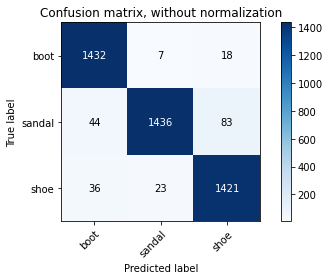

In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_CNN_block(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
class_names = np.array(['boot', 'sandal', 'shoe'])

# plot the confusion matrix for CNN model
plot_confusion_matrix(np.array(y_true), np.array(y_pred), classes=class_names, normalize=False)

# report the classification report for CNN model
print("~~~~~~~~~~~~~~~~~ Classification Report ~~~~~~~~~~~~~~~")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
print('The defined Model_CNN_block model has {} trainable parameters'.format(number_of_parameters(model_CNN_block)))


The defined Model_CNN_block model has 1199555 trainable parameters


learning rate: 0.0001

train loss: 0.6684 - train accuracy: 0.8888

test loss: 0.6406 - test accuracy: 0.9218

val loss: 0.6316 - val accuracy: 0.9327

---------------------------------------------

learning rate: 0.001

train loss: 0.6024 - train accuracy: 0.9489

test loss: 0.6090 - test accuracy: 0.9433

val loss: 0.6023 - val accuracy: 0.9473

---------------------------------------------

learning rate: 0.01

train loss: 1.2279 - train accuracy: 0.3236

test loss: 1.2041 - test accuracy: 0.3473

val loss: 1.2014 - val accuracy: 0.3500

---------------------------------------------

learning rate: 0.1

train loss: 1.2279 - train accuracy: 0.3236

test loss: 1.2041 - test accuracy: 0.3473

val loss: 1.2014 - val accuracy: 0.3500

---------------------------------------------

best learning rate based on val accuracy: 0.001

best learning rate based on val loss: 0.001

---------------------------------------------


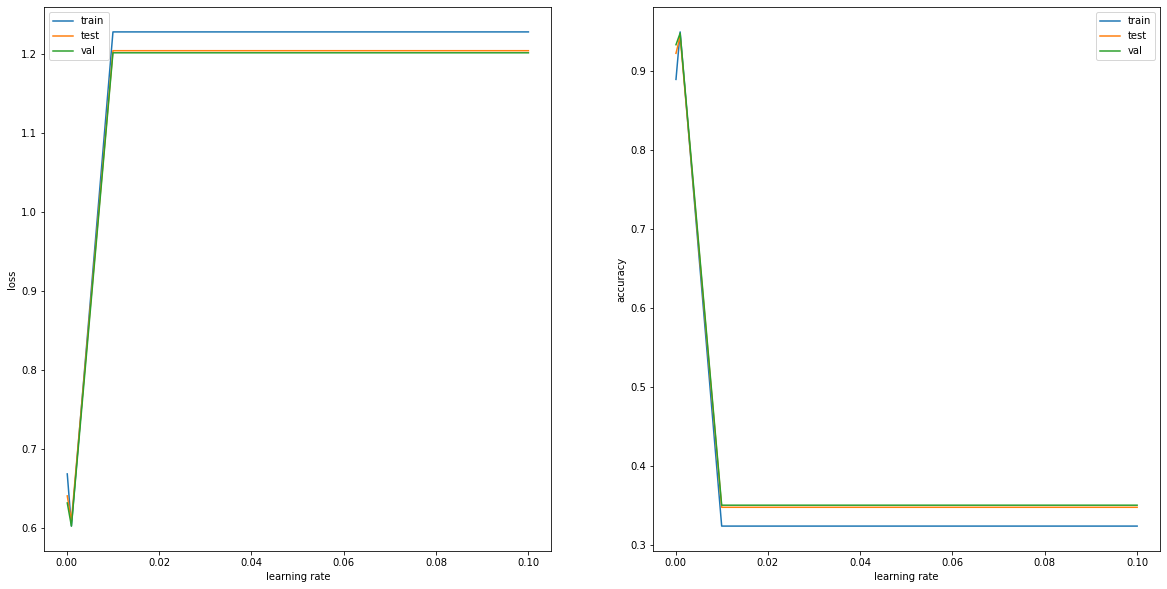

In [ ]:
# factorized_CNN like first CNN model (without blockdropout)
class CNN_factorized(nn.Module):
    def __init__(self):
        super(CNN_factorized, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 3, 1 , groups = 3) #factorized kernels
        self.in_conv_1 = nn.Conv2d(3,32,1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1 , groups = 16) #factorized kernels
        self.in_conv_2 = nn.Conv2d(32,64,1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.in_conv_1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.in_conv_2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)
### choose learning rate ###
learning_rate = plot_result_different_learning_rate(CNN_block(), epochs = 5)

In [ ]:
#train the CNN model with factorized convolution layer with 10 epoch with learning rate of 0.001 and momentum of 0.9 with Adam optimizer
model_CNN_factorized = CNN_factorized()
model_CNN_factorized.to(device)
writer = SummaryWriter('runs/CNN_factorized')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN_factorized.parameters(), lr=learning_rate)
train_loss_CNN_factorized, train_acc_CNN_factorized, test_loss_CNN_factorized, test_acc_CNN_factorized, val_loss_CNN_factorized, val_acc_CNN_factorized = train(model_CNN_factorized, trainloader, testloader, valloader, criterion, optimizer, epochs, writer=writer, writer_name = "CNN_factorized")
torch.save(model_CNN_factorized.state_dict(), 'model_CNN_factorized.pt')


Epoch 1/20 - Training loss: 0.7942 - Training accuracy: 0.7496

Test loss: 0.7435 - Test accuracy: 0.8027

Validation loss: 0.7291 - Validation accuracy: 0.8160

Epoch 2/20 - Training loss: 0.6920 - Training accuracy: 0.8566

Test loss: 0.6664 - Test accuracy: 0.8893

Validation loss: 0.6493 - Validation accuracy: 0.9087

Epoch 3/20 - Training loss: 0.6654 - Training accuracy: 0.8833

Test loss: 0.6706 - Test accuracy: 0.8827

Validation loss: 0.6593 - Validation accuracy: 0.8940

Epoch 4/20 - Training loss: 0.6486 - Training accuracy: 0.9020

Test loss: 0.6485 - Test accuracy: 0.9004

Validation loss: 0.6353 - Validation accuracy: 0.9173

Epoch 5/20 - Training loss: 0.6418 - Training accuracy: 0.9093

Test loss: 0.6297 - Test accuracy: 0.9211

Validation loss: 0.6159 - Validation accuracy: 0.9360

Epoch 6/20 - Training loss: 0.6247 - Training accuracy: 0.9272

Test loss: 0.6198 - Test accuracy: 0.9353

Validation loss: 0.6060 - Validation accuracy: 0.9473

Epoch 7/20 - Training loss: 

In [ ]:
print('The defined model_CNN_factorized has {} trainable parameters'.format(number_of_parameters(model_CNN_factorized)))
print('The CNN_factorized has {} trainable parameters less than CNN model'.format(number_of_parameters(model_CNN_factorized) - number_of_parameters(model_CNN)))

~~~~~~~~~~~~~~~~~ Classification Report ~~~~~~~~~~~~~~~

              precision    recall  f1-score   support



        boot       0.96      0.98      0.97      1457

      sandal       0.95      0.95      0.95      1563

        shoe       0.96      0.94      0.95      1480



    accuracy                           0.96      4500

   macro avg       0.96      0.96      0.96      4500

weighted avg       0.96      0.96      0.96      4500




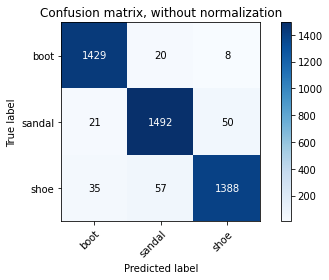

In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_CNN_factorized(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
class_names = np.array(['boot', 'sandal', 'shoe'])

# plot the confusion matrix for CNN model
plot_confusion_matrix(np.array(y_true), np.array(y_pred), classes=class_names, normalize=False)

# report the classification report for CNN model
print("~~~~~~~~~~~~~~~~~ Classification Report ~~~~~~~~~~~~~~~")
print(classification_report(y_true, y_pred, target_names=class_names))

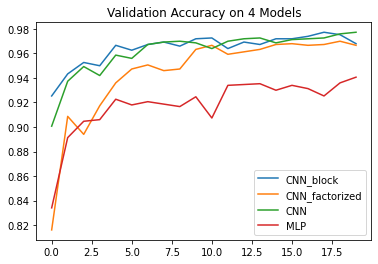

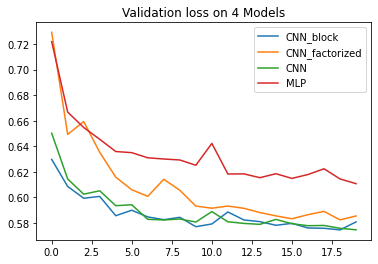

In [ ]:
# plot val_acc_CNN_block and val_acc_CNN_factorized and val_acc_CNN and val_acc_MLP
plt.plot(val_acc_CNN_block, label='CNN_block')
plt.plot(val_acc_CNN_factorized, label='CNN_factorized')
plt.plot(val_acc_CNN, label='CNN')
plt.plot(val_acc_MLP, label='MLP')
plt.legend()
plt.title('Validation Accuracy on 4 Models')
plt.show()
#plot val_loss_CNN_block and val_loss_CNN_factorized and val_loss_CNN and val_loss_MLP
plt.plot(val_loss_CNN_block, label='CNN_block')
plt.plot(val_loss_CNN_factorized, label='CNN_factorized')
plt.plot(val_loss_CNN, label='CNN')
plt.plot(val_loss_MLP, label='MLP')
plt.legend()
plt.title('Validation loss on 4 Models')
plt.show()


In [ ]:
# !tensorboard dev upload --logdir runs/mlp \
# --name "MLP with 10 epoch" \
# --description "MLP l"
# I plot my result with tensoarboard and screenshot is in folder

#### ANSWER to ASKED QUESTIONS #######
**** Q1 : Compare result of MLP moudle and CNN model ****

CNN model has less parameters than MLP but it Generalize better (as above plot) 
the reasons are : 
* CNN takes tensor as input so CNN can understand spatial relation(relation between nearby pixels of image)between pixels of images better thus for complicated images CNN will perform better than MLP
* it can also find the similar pattern even if the object is somewhat rotated/tilted using a concept called Pooling, which makes CNN more robust to changes in the position of the feature in the image
* CNNs are designed to be spatially invariant, that is — they are not sensitive to the position of, for example, object in the picture


****Q2 : BlockDropout VS dropout in CNN ****

in our dataset and this number of epochs, dropoutprob(0.2) other hyperparameters and we cant see huge different and they are so close BUT : 
blockdroput is good because near pixel in picture are related and just dropping one pixel cant make enough change (or input noise) in data so if we use spatial dropout with biggersize it has better result in generalization 

**** Q3 : Factorized CNN vs CNN ****

one of the most challenge in CNN is its high computation and memory complexity . a set of factorized kernels and their combinations are introduced as a drop-in replacement for the standard convolution to reduce the computation and memory cost meanwhile maintaining the model prediction power.


